<a href="https://colab.research.google.com/github/Aditya-Walia1/ML-Assignments/blob/main/Link_Prediction_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Community Link Prediction using Random Forest Classifier

In [ ]:
!pip install networkx node2vec python-louvain imbalanced-learn optuna shap scikit-learn matplotlib seaborn lightgbm


In [ ]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from node2vec import Node2Vec


In [ ]:
file_path = '/content/fb-forum.txt'
df = pd.read_csv(file_path, sep="\s+", header=None, names=['Source', 'Target', 'Timestamp'])

df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Create a graph from the Source-Target pairs
G = nx.from_pandas_edgelist(df, source='Source', target='Target', create_using=nx.Graph())

# Create positive samples (existing links)
positive_samples = df[['Source', 'Target']].copy()
positive_samples['Label'] = 1  # Label for existing links

# Generate negative samples (non-existing links)
all_nodes = list(G.nodes())
negative_samples = []
num_samples = len(positive_samples)

while len(negative_samples) < num_samples:
    source = np.random.choice(all_nodes)
    target = np.random.choice(all_nodes)
    if source != target and not G.has_edge(source, target):
        negative_samples.append([source, target])

negative_samples_df = pd.DataFrame(negative_samples, columns=['Source', 'Target'])
negative_samples_df['Label'] = 0
dataset = pd.concat([positive_samples, negative_samples_df], ignore_index=True)

centrality_measures = {
    'katz_centrality': nx.katz_centrality_numpy(G, alpha=0.005),
    'betweenness_centrality': nx.betweenness_centrality(G),
    'eigenvector_centrality': nx.eigenvector_centrality_numpy(G),
    'pagerank': nx.pagerank(G),
    'closeness_centrality': nx.closeness_centrality(G),
}

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)

def extract_features(source, target):
    features = {
        'degree_source': G.degree[source],
        'degree_target': G.degree[target],
        'common_neighbors': len(list(nx.common_neighbors(G, source, target))),
    }

    # Add additional features with error handling for missing centralities
    try:
        for name, centrality in centrality_measures.items():
            features[f'{name}_source'] = centrality[source]
            features[f'{name}_target'] = centrality[target]
    except KeyError:
        pass

    default_embedding = np.zeros(n2v_model.wv.vector_size)
    source_embedding = n2v_model.wv[source] if source in n2v_model.wv else default_embedding
    target_embedding = n2v_model.wv[target] if target in n2v_model.wv else default_embedding
    features['node2vec_similarity'] = np.dot(source_embedding, target_embedding)

    return features

# Create feature DataFrame
features_list = []
for _, row in dataset.iterrows():
    features = extract_features(row['Source'], row['Target'])
    features['Label'] = row['Label']
    features_list.append(features)

features_df = pd.DataFrame(features_list)

Computing transition probabilities:   0%|          | 0/899 [00:00<?, ?it/s]

In [ ]:
features_df

,degree_source,degree_target,common_neighbors,katz_centrality_source,katz_centrality_target,betweenness_centrality_source,betweenness_centrality_target,eigenvector_centrality_source,eigenvector_centrality_target,pagerank_source,pagerank_target,closeness_centrality_source,closeness_centrality_target,node2vec_similarity,Label
0,27,65,4,0.035183,0.041929,0.003431,0.013258,0.034254,0.086638,0.001848,0.004036,0.392826,0.436983,-0.000452,1
1,13,65,1,0.032808,0.041929,0.000384,0.013258,0.022394,0.086638,0.000894,0.004036,0.368335,0.436983,0.737394,1
2,12,50,2,0.032549,0.039267,0.000929,0.009392,0.016804,0.065082,0.000900,0.003160,0.364300,0.429049,0.398095,1
3,28,65,2,0.035371,0.041929,0.003131,0.013258,0.034931,0.086638,0.001822,0.004036,0.395769,0.436983,0.564444,1
4,26,65,4,0.035498,0.041929,0.001788,0.013258,0.057055,0.086638,0.001609,0.004036,0.422191,0.436983,0.919578,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67435,2,15,0,0.030713,0.033226,0.000011,0.000618,0.002322,0.029109,0.000286,0.001027,0.307009,0.384418,0.552060,0
67436,29,1,0,0.035582,0.030519,0.001948,0.000000,0.042427,0.000425,0.001801,0.000258,0.396994,0.262113,1.231225,0
67437,12,16,0,0.032605,0.033125,0.000282,0.001373,0.019780,0.015841,0.000833,0.001202,0.362975,0.361805,0.823474,0
67438,84,9,0,0.045119,0.031958,0.022327,0.000752,0.105131,0.010662,0.005293,0.000754,0.447880,0.350507,0.453690,0


In [ ]:
features_df.fillna(0, inplace=True)
X = features_df.drop('Label', axis=1)
y = features_df['Label']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9440
Precision: 0.9363
Recall: 0.9527
F1 Score: 0.9444


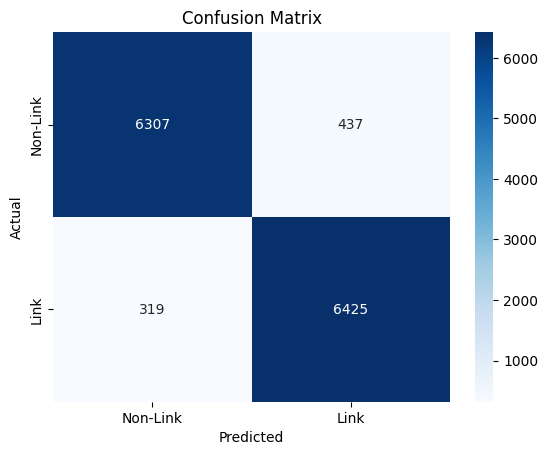

In [ ]:

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Link", "Link"], yticklabels=["Non-Link", "Link"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<ipython-input-24-18b911d528f6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=dataset, palette='viridis')


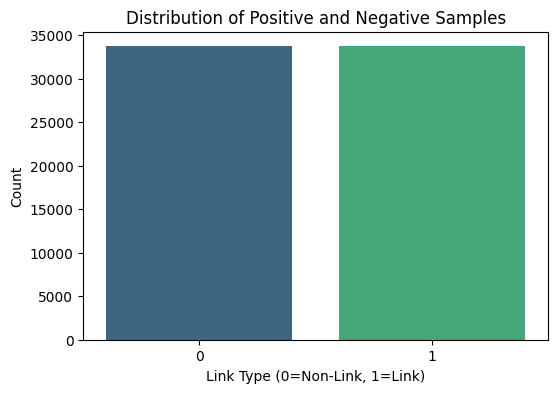

In [ ]:

plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=dataset, palette='viridis')
plt.title("Distribution of Positive and Negative Samples")
plt.xlabel("Link Type (0=Non-Link, 1=Link)")
plt.ylabel("Count")
plt.show()


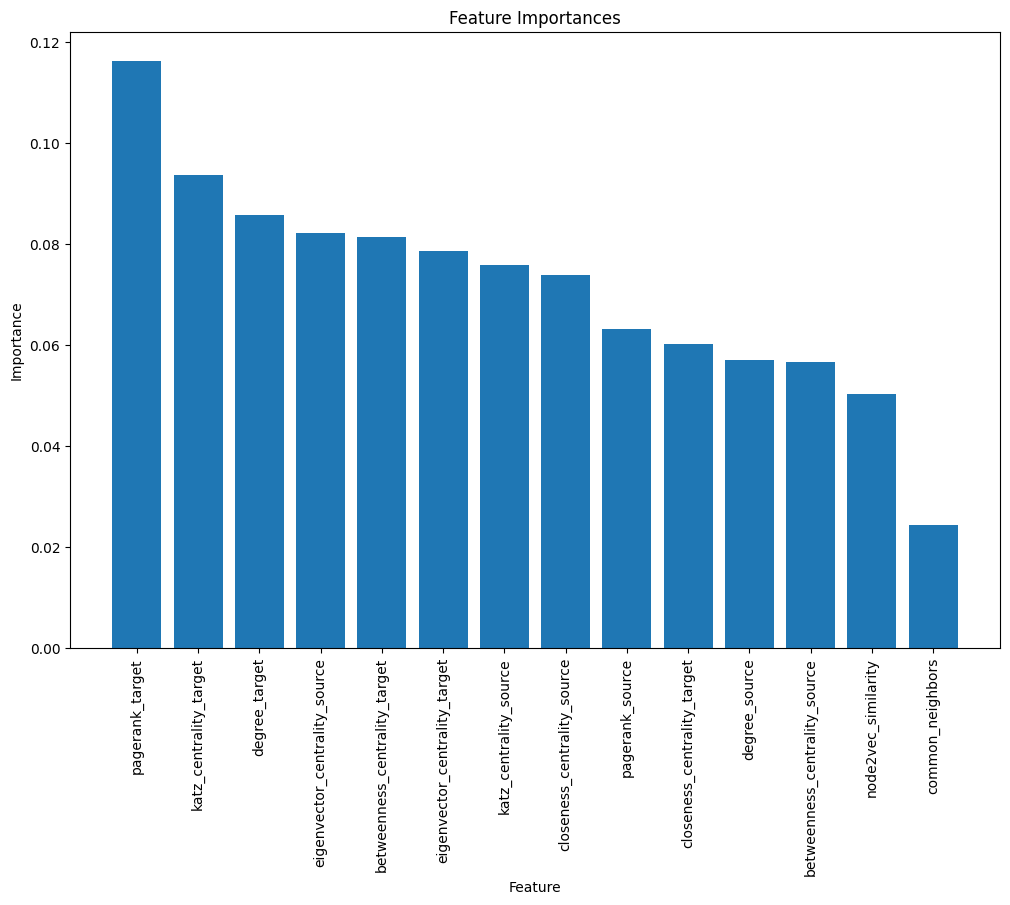

In [ ]:

importances = rf_classifier.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


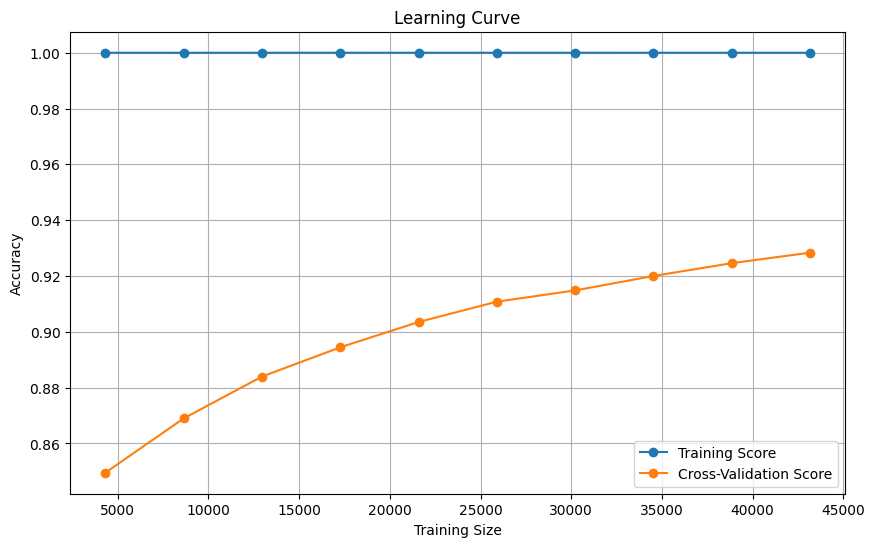

In [ ]:

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-Validation Score", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


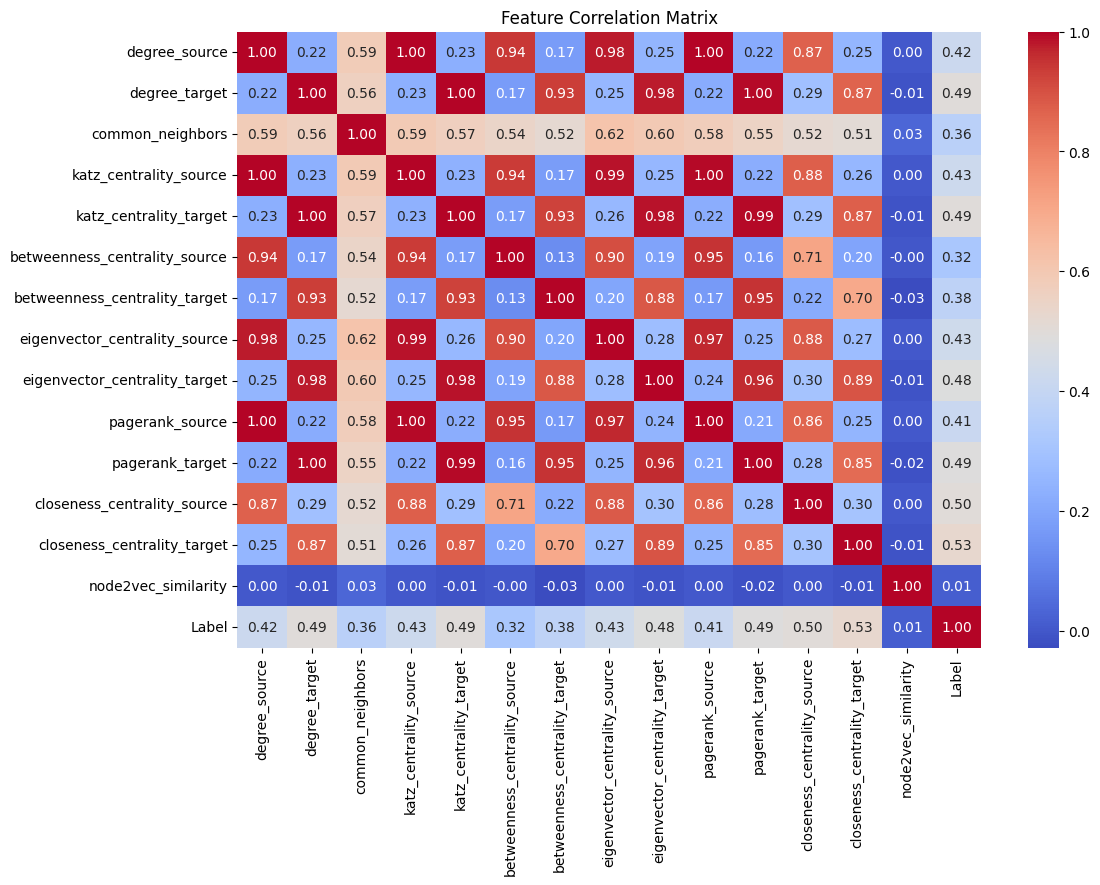

Highly correlated feature pairs (>|0.85|): [('degree_source', 'katz_centrality_source'), ('degree_source', 'betweenness_centrality_source'), ('degree_source', 'eigenvector_centrality_source'), ('degree_source', 'pagerank_source'), ('degree_source', 'closeness_centrality_source'), ('degree_target', 'katz_centrality_target'), ('degree_target', 'betweenness_centrality_target'), ('degree_target', 'eigenvector_centrality_target'), ('degree_target', 'pagerank_target'), ('degree_target', 'closeness_centrality_target'), ('katz_centrality_source', 'degree_source'), ('katz_centrality_source', 'betweenness_centrality_source'), ('katz_centrality_source', 'eigenvector_centrality_source'), ('katz_centrality_source', 'pagerank_source'), ('katz_centrality_source', 'closeness_centrality_source'), ('katz_centrality_target', 'degree_target'), ('katz_centrality_target', 'betweenness_centrality_target'), ('katz_centrality_target', 'eigenvector_centrality_target'), ('katz_centrality_target', 'pagerank_targe

In [ ]:
correlation_matrix = features_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

threshold = 0.85
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns
                   if i != j and abs(correlation_matrix.loc[i, j]) > threshold]
print(f"Highly correlated feature pairs (>|{threshold}|): {high_corr_pairs}")

features_to_remove = set()
for i, j in high_corr_pairs:
    features_to_remove.add(j)

X_reduced = features_df.drop(list(features_to_remove) + ['Label'], axis=1)


In [ ]:

X_scaled_reduced = scaler.fit_transform(X_reduced)
X_resampled_reduced, y_resampled_reduced = smote.fit_resample(X_scaled_reduced, y)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_resampled_reduced, y_resampled_reduced, test_size=0.2, random_state=42, stratify=y_resampled_reduced
)



In [ ]:
rf_classifier_reduced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = rf_classifier_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)
precision_reduced = precision_score(y_test_reduced, y_pred_reduced)
recall_reduced = recall_score(y_test_reduced, y_pred_reduced)
f1_reduced = f1_score(y_test_reduced, y_pred_reduced)

print("\nModel Performance After Feature Removal:")
print(f"Accuracy: {accuracy_reduced:.4f}")
print(f"Precision: {precision_reduced:.4f}")
print(f"Recall: {recall_reduced:.4f}")
print(f"F1 Score: {f1_reduced:.4f}")





Model Performance After Feature Removal:
Accuracy: 0.8876
Precision: 0.8539
Recall: 0.9352
F1 Score: 0.8927


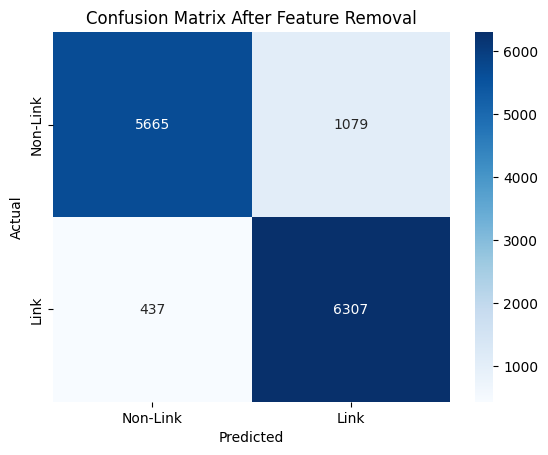

In [ ]:
conf_matrix_reduced = confusion_matrix(y_test_reduced, y_pred_reduced)
sns.heatmap(conf_matrix_reduced, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Link", "Link"], yticklabels=["Non-Link", "Link"])
plt.title("Confusion Matrix After Feature Removal")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()